https://www.kaggle.com/c/integer-sequence-learning

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
tqdm.pandas()

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Data

In [2]:
data = pd.read_csv('Sequences.csv')

In [3]:
data.head()

,Sequence
0,"1,3,13,87,1053,28576,2141733,508147108,4021352..."
1,"1,2,1,5,5,1,11,16,7,1,23,44,30,9,1,47,112,104,..."
2,"1,2,4,5,8,10,16,20,32,40,64,80,128,160,256,320..."
3,"1,8,25,83,274,2275,132224,1060067,3312425,1099..."
4,"1,111,12211,1343211,147753211,16252853211,1787..."


In [4]:
len(data)

227690

Train Dataset: 113845
    
Test Dataset: 113845    

In [5]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
print(len(data))

225567


In [6]:
data['Sequence'] = list(map(lambda x: list(map(int, x.split(','))), data['Sequence']))

In [7]:
data['Sequence'][0]

[1,
 3,
 13,
 87,
 1053,
 28576,
 2141733,
 508147108,
 402135275365,
 1073376057490373,
 9700385489355970183,
 298434346895322960005291,
 31479360095907908092817694945,
 11474377948948020660089085281068730]

In [8]:
data['Solved'] = ''

In [9]:
data['Length'] = data['Sequence'].progress_apply(len)

In [10]:
print('Max:', data['Length'].max())
print('99th:', data['Length'].quantile(0.99))
print('75th:', data['Length'].quantile(0.75))
print('Median:', data['Length'].median())
print('25th:', data['Length'].quantile(0.25))
print('1st:', data['Length'].quantile(0.01))
print('Min:', data['Length'].min())

Max: 348
99th: 105.0
75th: 58.0
Median: 34.0
25th: 18.0
1st: 4.0
Min: 1


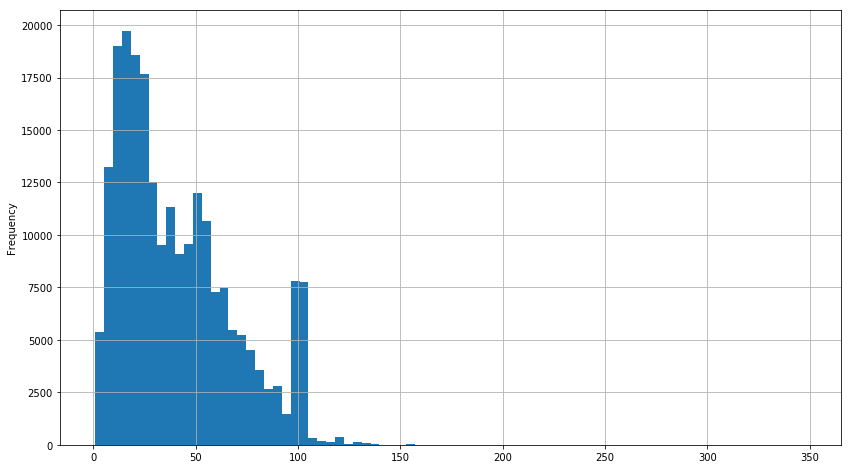

In [11]:
data['Length'].plot.hist(figsize=(14,8), grid=True, bins=80)

In [12]:
data

,Sequence,Solved,Length
0,"[1, 3, 13, 87, 1053, 28576, 2141733, 508147108...",,14
1,"[1, 2, 1, 5, 5, 1, 11, 16, 7, 1, 23, 44, 30, 9...",,57
2,"[1, 2, 4, 5, 8, 10, 16, 20, 32, 40, 64, 80, 12...",,41
3,"[1, 8, 25, 83, 274, 2275, 132224, 1060067, 331...",,20
4,"[1, 111, 12211, 1343211, 147753211, 1625285321...",,12
...,...,...,...
225562,"[0, 2, 6, 20, 72, 274, 1086, 4438, 18570, 7917...",,26
225563,"[1, 15, 208, 2389, 24845, 243697, 2348885, 228...",,15
225564,"[0, 0, 2, 3, 5, 7, 11, 13, 24, 30, 36, 46, 50,...",,57
225565,"[1, 3, 5, 9, 15, 25, 27, 45, 75, 81, 125, 135,...",,46


# Sequences

## Recurrence Relations

In [13]:
def checkRecurrence(seq, order= 2, minlength = 7):

    if len(seq)< max((2*order+1), minlength):
        return None
    
    # Set up the system of equations 
    A,b = [], []
    for i in range(order):
        A.append(seq[i:i+order])
        b.append(seq[i+order])
    A,b =np.array(A), np.array(b)
    try: 
        if np.linalg.det(A)==0:
            return None
    except TypeError:
        return None
   
    #  Solve for the coefficients (c0, c1, c2, ...)
    coeffs = np.linalg.inv(A).dot(b)  
    
    #  Check if the next terms satisfy recurrence relation
    for i in range(2*order, len(seq)):
        predict = np.sum(coeffs*np.array(seq[i-order:i]))
        if abs(predict-seq[i])>10**(-2):
            return None
    
    return list(coeffs)

In [14]:
def predictNextTerm_Recurrence(seq, coeffs):
    order = len(coeffs)
    predict = np.sum(coeffs*np.array(seq[-order:]))
    return int(round(predict))

### 10th - 2nd Order Sequences

Solving 10 order


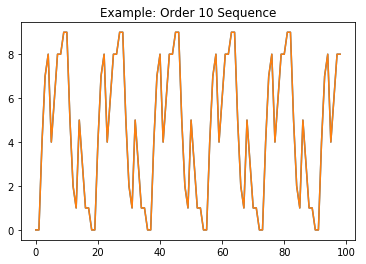


Solved order 10: 638 (0.28%)
Solving 9 order


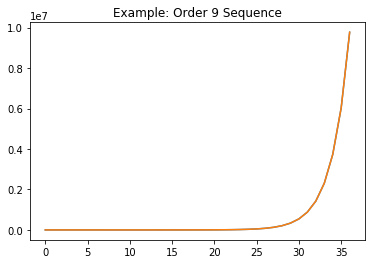


Solved order 9: 768 (0.34%)
Solving 8 order


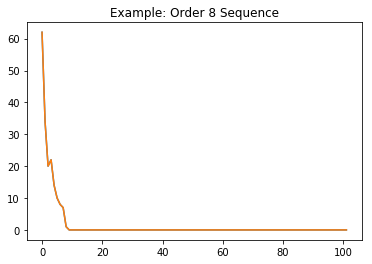


Solved order 8: 780 (0.35%)
Solving 7 order


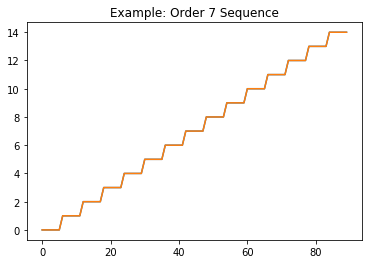


Solved order 7: 1032 (0.46%)
Solving 6 order


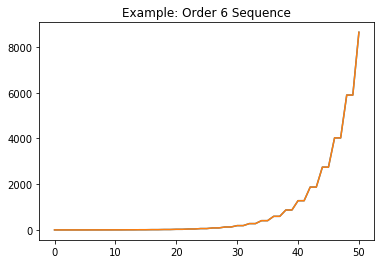


Solved order 6: 1751 (0.78%)
Solving 5 order


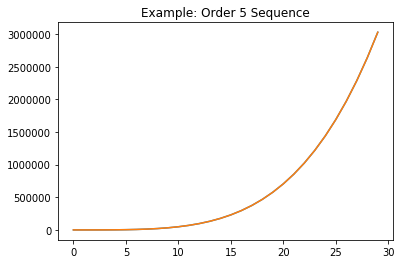


Solved order 5: 2503 (1.11%)
Solving 4 order


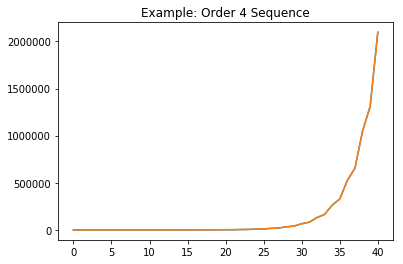


Solved order 4: 3305 (1.47%)
Solving 3 order


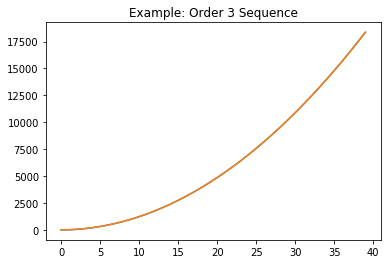


Solved order 3: 3838 (1.7%)
Solving 2 order


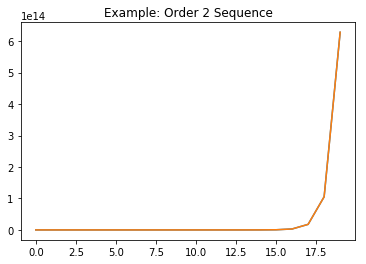


Solved order 2: 2616 (1.16%)


In [15]:
for order in range(10, 1, -1):
    print(f'Solving {order} order')
    count = 0
    for i, seq in tqdm(enumerate(data['Sequence'])):
        coeff = checkRecurrence(seq,order)
        if coeff:
            count += 1
            data.loc[i, 'Solved'] = f'r{order}'
            if count == 1:
                fig, ax = plt.subplots()
                ax.plot(seq)
                plt.plot(seq)
                ax.set_title(f'Example: Order {order} Sequence')
                plt.show()

    print(f'Solved order {order}: {count} ({round((count*100)/len(data),2)}%)')

## Polynomial Sequence

In [16]:
def checkPolynomial(seq, order= 2, minlength = 4):

    if len(seq)< max((2*order+1), minlength):
        return None
    
    # Set up the system of equations 
    A = [[i**j for j in range(order+1)] for i in range(order+1)]
    b = seq[:order+1]
    A,b =np.array(A), np.array(b)
    try: 
        if np.linalg.det(A)==0:
            return None
    except TypeError:
        return None
   
    #  Solve for the coefficients (c0, c1, c2, ...)
    coeffs = np.linalg.inv(A).dot(b)  
    
    #  Check if the next terms satisfy recurrence relation
    for i in range(order, len(seq)):
        predict = np.sum(coeffs*np.array([i**j for j in range(order+1)]))
        if abs(predict-seq[i])>10**(-2):
            return None
    
    return list(coeffs)

In [17]:
def predictNextTerm_Polynomial(seq, coeffs):
    order = len(coeffs)
    predict = np.sum(coeffs*np.array([i**j for j in range(order+1)]))
    return int(round(predict))

### 10th - 1st Order Sequence

Solving 10 order


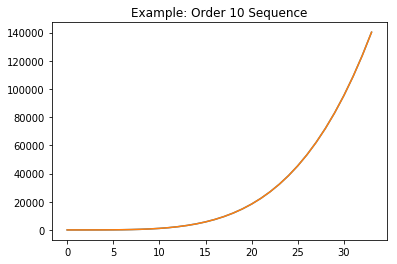


Solved order 10: 796 (0.35%)
Solving 9 order


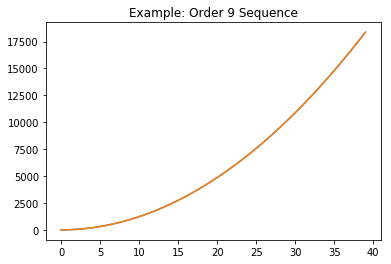


Solved order 9: 2968 (1.32%)
Solving 8 order


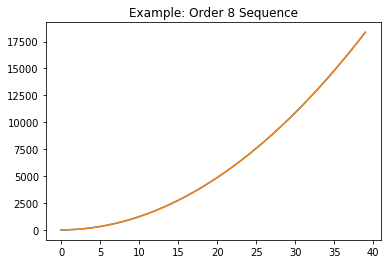


Solved order 8: 4041 (1.79%)
Solving 7 order


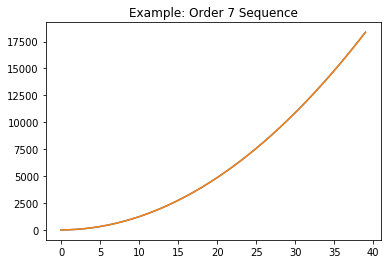


Solved order 7: 4069 (1.8%)
Solving 6 order


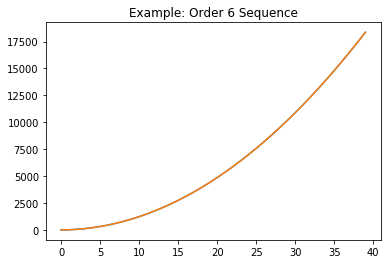


Solved order 6: 3995 (1.77%)
Solving 5 order


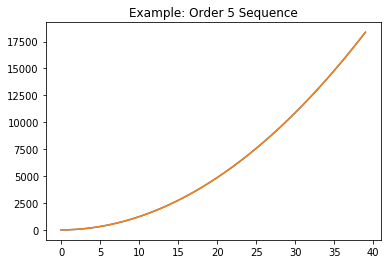


Solved order 5: 3653 (1.62%)
Solving 4 order


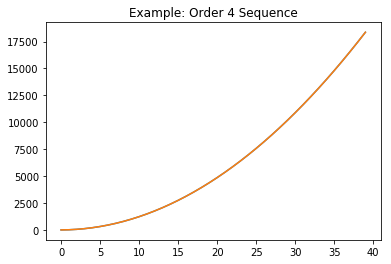


Solved order 4: 3284 (1.46%)
Solving 3 order


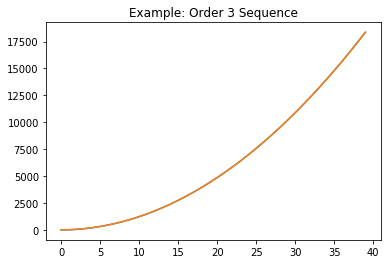


Solved order 3: 2627 (1.16%)
Solving 2 order


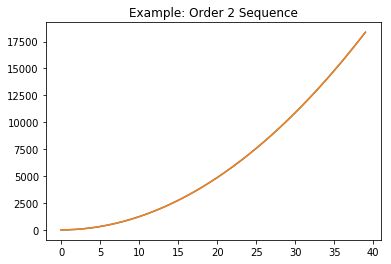


Solved order 2: 1885 (0.84%)
Solving 1 order


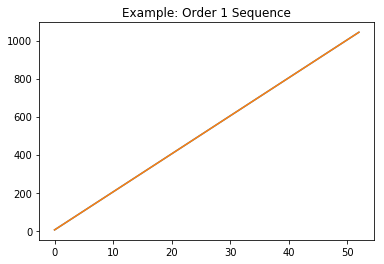


Solved order 1: 599 (0.27%)


In [18]:
for order in range(10, 0, -1):
    print(f'Solving {order} order')
    count = 0
    for i, seq in tqdm(enumerate(data['Sequence'])):
        coeff = checkPolynomial(seq,order)
        if coeff:
            count += 1
            data.loc[i, 'Solved'] = f'p{order}'
            if count == 1:
                fig, ax = plt.subplots()
                ax.plot(seq)
                plt.plot(seq)
                ax.set_title(f'Example: Order {order} Sequence')
                plt.show()

    print(f'Solved order {order}: {count} ({round((count*100)/len(data),2)}%)')

## Unit Sequences

In [19]:
def checkUnit(seq):
    return len(set(seq)) == 1

In [20]:
def predictNextTerm_Unit(seq):
    return seq[0]


Solved: 91 (0.04%)


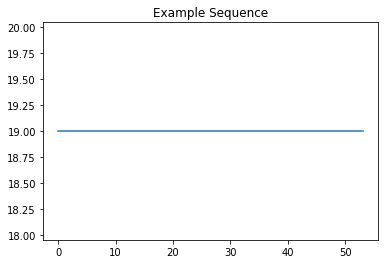

In [21]:
count = 0
for i, seq in tqdm(enumerate(data['Sequence'])):
    if checkUnit(seq):
        count += 1
        data.loc[i, 'Solved'] = 'un'
        if count == 1:
            plt.plot(seq)
            plt.title('Example Sequence')
        
print(f'Solved: {count} ({round((count*100)/len(data),2)}%)')

## Binary Sequences

In [22]:
def checkBinary(seq):
    return len(set(seq)) == 2


Solved: 2319 (1.03%)


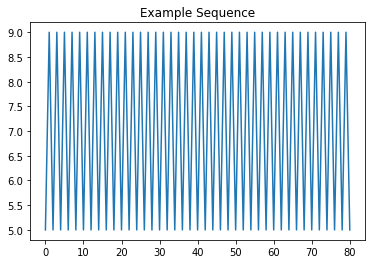

In [23]:
count = 0
for i, seq in tqdm(enumerate(data['Sequence'])):
    if checkBinary(seq):
        count += 1
        data.loc[i, 'Solved'] = 'bi'
        if count == 1:
            plt.plot(seq)
            plt.title('Example Sequence')
        
print(f'Solved: {count} ({round((count*100)/len(data),2)}%)')

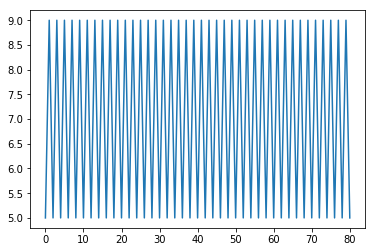

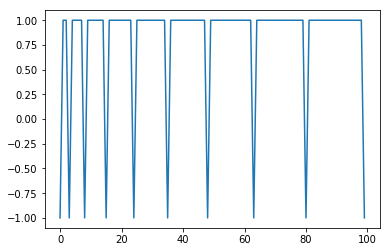

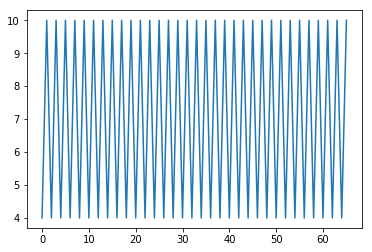

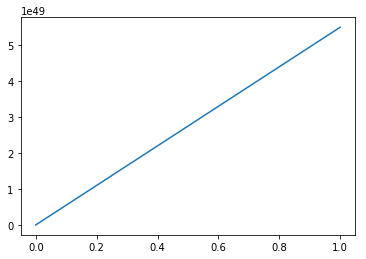

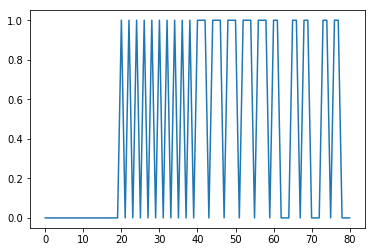

In [24]:
count = 0
for seq in data[data['Solved'] == 'bi']['Sequence']:
    count += 1
    fig, ax = plt.subplots()
    ax.plot(seq)
    if count == 5:
        break

## Geometric Progression

In [25]:
def checkGeometricProgression(seq):
    if len(seq) > 3:
        a, b, c, *D = seq
        r = None
        if b**2 == a*c:
            try:
                r = b/a
            except ZeroDivisionError:
                return None
        if r:
            for i, d in enumerate(D):
                if d != a*(r**(i+3)):
                    r = None
                    break
        return r
    return None

In [26]:
def predictNextTerm_Geometric(seq, r):
    return seq[-1]*r


Solved: 154 (0.07%)


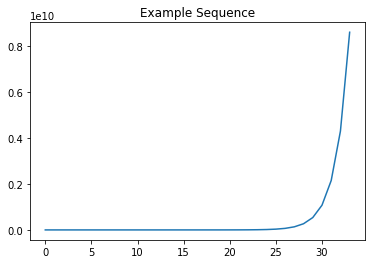

In [27]:
count = 0
for i, seq in tqdm(enumerate(data['Sequence'])):
    if checkGeometricProgression(seq):
        count += 1
        data.loc[i, 'Solved'] = 'gp'
        if count == 1:
            plt.plot(seq)
            plt.title('Example Sequence')
        
print(f'Solved: {count} ({round((count*100)/len(data),2)}%)')

# Final Standings

In [28]:
data['Solved'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

       91.0%
r4     1.11%
r3     1.09%
bi     1.03%
r2     0.86%
r5      0.8%
r6     0.68%
p2     0.57%
r7     0.43%
p3     0.34%
r8     0.33%
r9     0.33%
p4      0.3%
r10    0.27%
p1     0.25%
p5     0.17%
p6     0.17%
p7     0.07%
p8     0.07%
gp     0.07%
un     0.03%
p9     0.02%
p10     0.0%
Name: Solved, dtype: object